trajectory forecasting with adaptive updating 

**Main Features**
- Brent Crude, WTI Crude, Dutch TTF Gas, Henry Hub Gas
- Equinor (EQNR.OL): Open, Close, High, Low, Volume, Market Cap
- OSEBX Index: Open, Close, High, Low, Volume
- VIX (volatility index)
- Dollar Index (DXY)

**Relevant Stocks**
- **Norway**: Aker BP (AKRBP), DNO (DNO), Vår Energi (VAR), Petroleum Geo-Services (PGS), BW Offshore (BWO), Frontline (FRO)
- **US/Global**: Exxon (XOM), Chevron (CVX), Shell (SHEL), BP (BP), TotalEnergies (TTE), ConocoPhillips (COP), Occidental (OXY)

**Stock Exchanges**
- S&P 500, NASDAQ, Dow Jones
- FTSE 100, DAX, CAC 40
- Nikkei 225, Hang Seng

**Commodity Prices**
- Gold (XAU), Silver (XAG)
- **Currencies**: USD/NOK, EUR/NOK, GBP/NOK, SEK/NOK, USD/EUR
- Coal (API2), Uranium (UX)
- Carbon Credits (EU ETS)

**Economic Indicators**
- **Interest Rates**: Norway (Norges Bank), US Fed Funds, ECB, BoE, BoJ, PBoC
- **Inflation**: Norway CPI, US CPI, EU HICP
- **Unemployment**: Norway, US, EU rates
- **Analyst Targets**: Equinor consensus price targets, EPS estimates


#### Fetch Dependencies

# Data fetching
import yfinance as yf

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optuna optimization
import optuna
from optuna.trial import TrialState

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Date and time handling
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

#### Collect Data

In [4]:
# CELL 1: COLLECT DATA

def collect_data(start_date="2021-01-01", end_date=None):
    """Collect stock data and return as DataFrame"""
    end_date = end_date or datetime.now().strftime('%Y-%m-%d')
    
    # Updated tickers based on research
    tickers = {
        # Main stock
        'EQNR.OL': 'equinor',
       
        # Energy commodities
        'BZ=F': 'brent_crude',
        'CL=F': 'wti_crude',
        'TTF=F': 'ttf_gas',
        'NG=F': 'henry_hub',
       
        # Norwegian energy stocks
        'AKRBP.OL': 'aker_bp',
        'DNO.OL': 'dno',
        'VAR.OL': 'var_energi',
        'PGS.OL': 'pgs',
        'BWO.OL': 'bw_offshore',
        'FRO.OL': 'frontline',
       
        # Global energy stocks
        'XOM': 'exxon',
        'CVX': 'chevron',
        'SHEL': 'shell',
        'BP': 'bp',
        'TTE': 'totalenergies',
        'COP': 'conocophillips',
        'OXY': 'occidental',
       
        # Indices
        'OSEBX.OL': 'osebx',
        '^GSPC': 'sp500',
        '^IXIC': 'nasdaq',
        '^DJI': 'dow_jones',
        '^FTSE': 'ftse100',
        '^GDAXI': 'dax',
        '^FCHI': 'cac40',
        '^N225': 'nikkei',
        '^HSI': 'hang_seng',
       
        # Volatility and Dollar
        '^VIX': 'vix',
        'DX-Y.NYB': 'dollar_index',
       
        # Commodities
        'GC=F': 'gold',
        'SI=F': 'silver',
       
        # Currencies
        'NOK=X': 'usd_nok',
        'EURNOK=X': 'eur_nok',
        'GBPNOK=X': 'gbp_nok',
        'SEKNOK=X': 'sek_nok',
        'EURUSD=X': 'eur_usd'
    }
    
    all_data = {}
    
    # Download each ticker separately to avoid alignment issues
    for ticker, name in tickers.items():
        try:
            print(f"Downloading {name}...")
            # Download individually
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if len(data) > 0:
                # Only keep OHLC and Volume columns
                cols_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
                data = data[[c for c in cols_to_keep if c in data.columns]]
                # Handle column renaming - columns might be strings or tuples
                new_cols = []
                for col in data.columns:
                    if isinstance(col, tuple):
                        col_name = col[0] if len(col) > 0 else str(col)
                    else:
                        col_name = str(col)
                    new_cols.append(f"{name}_{col_name.lower()}")
                data.columns = new_cols
                all_data[name] = data
                print(f"  ✓ {name}: {len(data)} rows")
            else:
                print(f"  ✗ No data received for {ticker}")
                
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
    
    if not all_data:
        print("No data collected")
        return pd.DataFrame()
    
    # Combine using outer join to keep all dates
    df = pd.concat(all_data.values(), axis=1, join='outer')
    print(f"Combined data: {len(df)} rows, {len(df.columns)} columns")
    
    # Check initial NaN percentage
    nan_pct = df.isnull().sum().sum() / df.size * 100
    print(f"Initial NaN percentage: {nan_pct:.2f}%")
    
    # Keep only dates where Equinor traded (removes weekends/holidays)
    if 'equinor_close' in df.columns:
        before_filter = len(df)
        df = df[df['equinor_close'].notna()]
        print(f"Filtered to Equinor trading days: {before_filter} → {len(df)} rows")
    
    # Forward fill then backward fill to handle gaps
    df = df.ffill().bfill()
    
    # For any remaining NaNs at the beginning, drop those rows
    # This happens when some tickers start trading later than others
    first_valid_idx = df.first_valid_index()
    last_valid_idx = df.last_valid_index()
    if first_valid_idx and last_valid_idx:
        df = df.loc[first_valid_idx:last_valid_idx]
    
    # Final check for NaN percentage
    nan_count = df.isnull().sum().sum()
    if nan_count > 0:
        nan_pct_final = nan_count / df.size * 100
        print(f"Warning: {nan_count} NaN values remain ({nan_pct_final:.2f}%)")
        # Show which columns have NaNs
        nan_cols = df.columns[df.isnull().any()].tolist()
        if nan_cols:
            print(f"  Columns with NaNs: {nan_cols}")
    
    print(f"\nFinal data: {len(df)} rows, {len(df.columns)} columns")
    if len(df) > 0:
        print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
        nan_pct_final = df.isnull().sum().sum() / df.size * 100
        print(f"Final NaN percentage: {nan_pct_final:.2f}%")
    else:
        print("WARNING: No data remaining after processing")
    
    return df

In [5]:
# Run collection
data = collect_data(start_date="2001-01-01")

  ✓ equinor: 6255 rows
  ✓ brent_crude: 4505 rows
  ✓ wti_crude: 6198 rows
  ✓ ttf_gas: 1981 rows
  ✓ henry_hub: 6200 rows
  ✓ aker_bp: 4185 rows
  ✓ dno: 6255 rows
  ✓ var_energi: 894 rows
  ✓ pgs: 5227 rows
  ✓ bw_offshore: 4843 rows
  ✓ frontline: 6255 rows
  ✓ exxon: 6207 rows



1 Failed download:
['CVX']: Timeout('Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 114074 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


  ✗ No data received for CVX
  ✓ shell: 6207 rows
  ✓ bp: 6207 rows
  ✓ totalenergies: 6207 rows
  ✓ conocophillips: 6207 rows
  ✓ occidental: 6207 rows
  ✓ osebx: 3119 rows
  ✓ sp500: 6207 rows
  ✓ nasdaq: 6207 rows
  ✓ dow_jones: 6207 rows
  ✓ ftse100: 6235 rows
  ✓ dax: 6269 rows
  ✓ cac40: 6312 rows
  ✓ nikkei: 6045 rows
  ✓ hang_seng: 6082 rows
  ✓ vix: 6207 rows
  ✓ dollar_index: 6232 rows
  ✓ gold: 6194 rows
  ✓ silver: 6196 rows
  ✓ usd_nok: 6108 rows
  ✓ eur_nok: 6407 rows
  ✓ gbp_nok: 5665 rows
  ✓ sek_nok: 5197 rows
  ✓ eur_usd: 5649 rows
Combined data: 6440 rows, 175 columns
Initial NaN percentage: 12.79%
Filtered to Equinor trading days: 6440 → 6255 rows

Final data: 6255 rows, 175 columns
Date range: 2001-01-01 to 2025-09-08
Final NaN percentage: 0.00%


#### Rate of Change

In [6]:
# Add rate of change features
def add_rate_of_change(df):
    """Add rate of change features to existing dataframe"""
    
    # Key assets for rate of change analysis
    key_assets = ['equinor', 'brent_crude', 'wti_crude', 'usd_nok', 'vix']
    
    for asset in key_assets:
        close_col = f'{asset}_close'
        if close_col in df.columns:
            # First derivative (daily returns)
            df[f'{asset}_return'] = df[close_col].pct_change()
            
            # Second derivative (acceleration)
            df[f'{asset}_acceleration'] = df[f'{asset}_return'].diff()
            
            # Volatility momentum (20-day rolling vol change)
            rolling_vol = df[f'{asset}_return'].rolling(20).std()
            df[f'{asset}_vol_momentum'] = rolling_vol.pct_change()
    
    # Cross-asset correlation momentum (Equinor vs Brent)
    if 'equinor_return' in df.columns and 'brent_crude_return' in df.columns:
        rolling_corr = df['equinor_return'].rolling(20).corr(df['brent_crude_return'])
        df['eq_brent_corr_momentum'] = rolling_corr.diff()
    
    # Drop initial NaN rows created by calculations
    df = df.dropna()
    
    return df

# Apply to your data
data = add_rate_of_change(data)
print(f"After adding rate of change: {data.shape}")

After adding rate of change: (4547, 191)


#### Print Data

In [7]:
# CELL 2: PRINT HEAD OF DATA
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Columns: {len(data.columns)}")
print(f"Remaining NaNs: {data.isnull().sum().sum()}")
print(f"NaN percentage: {data.isnull().sum().sum() / data.size * 100:.2f}%")
data.head()

Shape: (4547, 191)
Date range: 2007-08-01 to 2025-09-08
Columns: 191
Remaining NaNs: 0
NaN percentage: 0.00%


,equinor_open,equinor_high,equinor_low,equinor_close,equinor_volume,brent_crude_open,brent_crude_high,brent_crude_low,brent_crude_close,brent_crude_volume,...,wti_crude_return,wti_crude_acceleration,wti_crude_vol_momentum,usd_nok_return,usd_nok_acceleration,usd_nok_vol_momentum,vix_return,vix_acceleration,vix_vol_momentum,eq_brent_corr_momentum
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-01,82.032875,82.632531,81.073426,82.032875,9960755.0,77.000000,77.059998,74.860001,75.349998,3930.0,...,-0.021481,-0.039442,0.091400,-0.001920,-0.002212,0.004430,0.006378,-0.120599,-0.001098,0.066993
2007-08-02,82.512563,82.632494,80.593666,81.792976,10785522.0,75.220001,76.209999,74.269997,75.760002,6180.0,...,0.004312,0.025793,-0.000461,-0.005170,-0.003250,0.030909,-0.103507,-0.109884,0.057004,0.033637
2007-08-03,81.912929,82.152791,80.713618,81.433205,11141460.0,75.389999,76.000000,74.529999,74.750000,4387.0,...,-0.017955,-0.022267,0.037209,-0.001260,0.003910,-0.003720,0.185674,0.289181,0.064666,-0.039793
2007-08-06,79.394376,80.353825,77.955203,78.075134,13812341.0,74.540001,74.599998,70.870003,71.169998,7201.0,...,-0.045310,-0.027355,0.216845,-0.000951,0.000310,-0.001964,-0.088235,-0.273909,0.039011,0.236648
2007-08-07,78.794721,79.274445,77.835272,78.075134,19840460.0,70.800003,72.010002,70.559998,71.800003,6775.0,...,0.004996,0.050306,-0.003878,0.004309,0.005260,0.001329,-0.060157,0.028078,-0.035674,0.004525


#### Save Matrix to CSV

# CELL 3: SAVE TO CSV
filepath = "data/equinor_data_8sept.csv"
data.to_csv(filepath)
print(f"Saved {len(data)} rows to {filepath}")

### Model

Using device: mps
ENSEMBLE BAYESIAN 30-DAY FORECAST MODEL

1. Loading data...
   Features: 25
   Samples: 4517

2. Training ensemble models...
Building pattern library...
Detecting market regimes...
Calculating base rates...
Training adjustment network...

3. Running backtest...

Backtest Results:
   Direction Accuracy: 50.7%
   Mean Absolute Error: 0.0146

4. Generating 30-day forecast...

5. Creating visualizations...


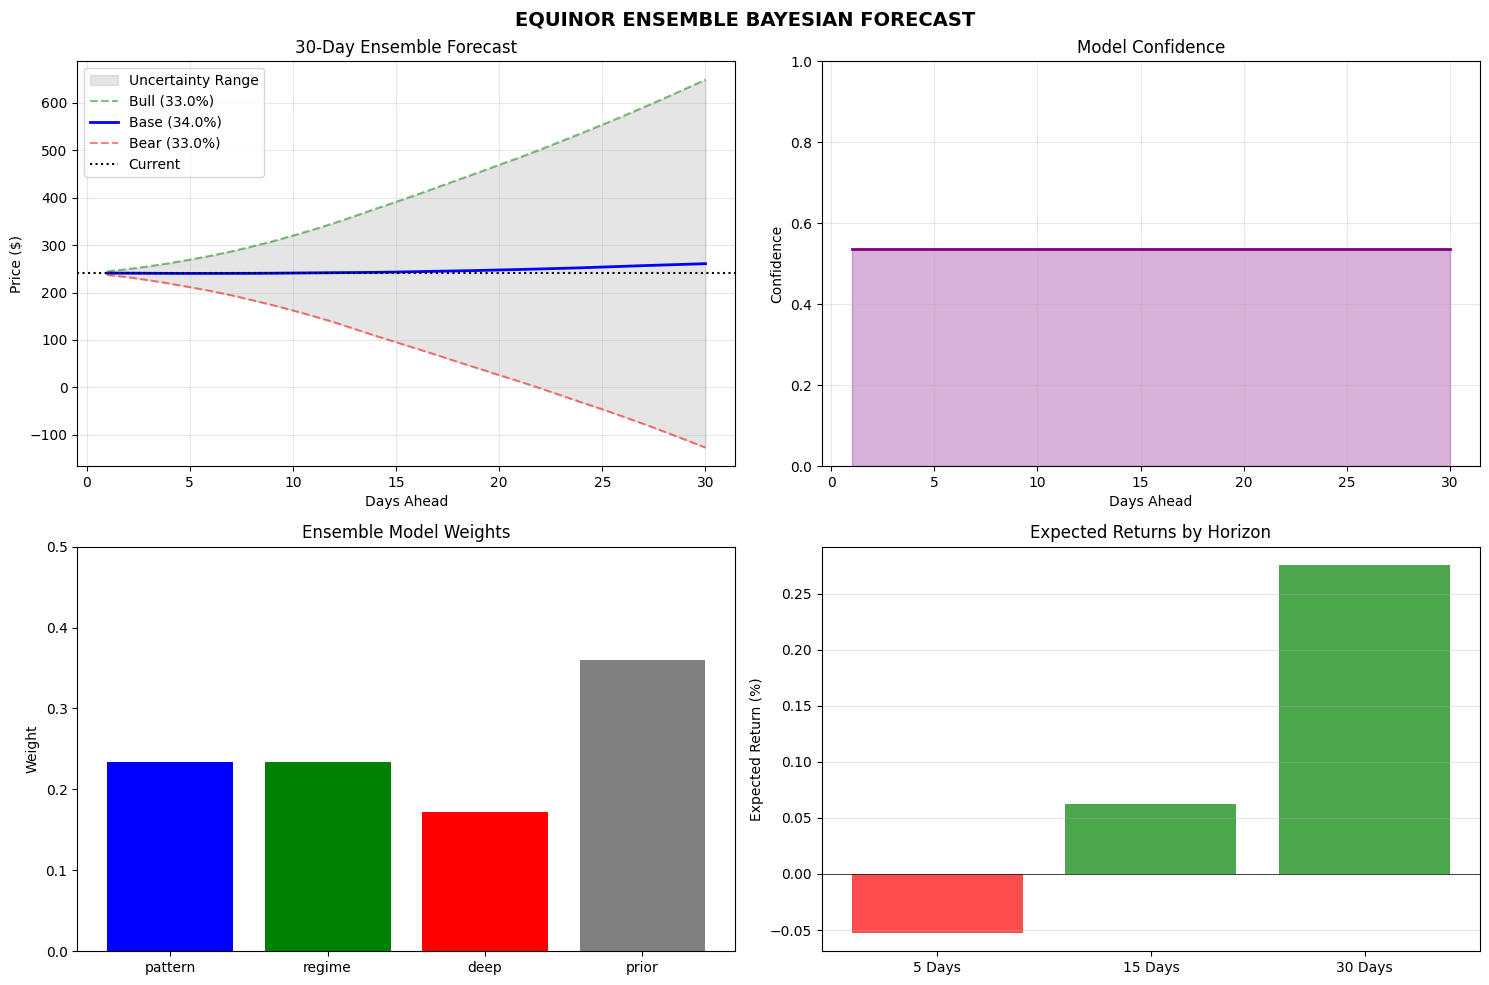


30-DAY FORECAST SUMMARY
Current Price: $241.00
Model Confidence: 53.7%

Scenario Weights:
   Bull: 33.0%
   Base: 34.0%
   Bear: 33.0%

Day  1: $240.99 (-0.0%)

Day  5: $240.37 (-0.0%)

Day 10: $241.16 (+0.2%)

Day 15: $243.25 (+0.3%)

Day 30: $260.92 (+0.6%)

Ensemble model ready. Updates will improve predictions.


In [10]:
"""
Ensemble Bayesian Architecture for 15-30 Day Equinor Price Prediction
Combines Pattern Library, Regime Detection, and Deep Adjustment Models
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================================
# DATA STRUCTURES
# ============================================================================

@dataclass
class MarketState:
    """Represents market state at a point in time"""
    date: datetime
    features: np.ndarray  # 196 features
    forward_returns: np.ndarray  # 30-day forward returns
    regime: int  # 0-6 regime label
    volatility_profile: float
    key_events: List[str]

@dataclass
class PredictionSet:
    """Holds predictions with uncertainty"""
    dates: np.ndarray
    bull_scenario: np.ndarray  # Upper trajectory
    base_scenario: np.ndarray  # Most likely trajectory  
    bear_scenario: np.ndarray  # Lower trajectory
    weights: np.ndarray  # [bull_weight, base_weight, bear_weight]
    confidence: np.ndarray  # Daily confidence scores

# ============================================================================
# DATA PREPARATION
# ============================================================================

def prepare_ensemble_data(filepath='data/equinor_data_8sept.csv'):
    """Prepare data with focus on robustness over complexity"""
    data = pd.read_csv(filepath, index_col=0, parse_dates=True)
    
    # Core features only - avoid overfitting
    features = []
    
    # Price-based features (most reliable)
    for asset in ['equinor', 'brent_crude', 'osebx', 'usd_nok']:
        if f'{asset}_close' in data.columns:
            close = data[f'{asset}_close']
            # Simple returns at multiple scales
            for period in [1, 5, 10, 20]:
                features.append(close.pct_change(period))
            # Normalized price position
            ma20 = close.rolling(20).mean()
            features.append((close - ma20) / ma20)
    
    # Volatility features
    equinor_returns = data['equinor_close'].pct_change()
    for period in [5, 20]:
        features.append(equinor_returns.rolling(period).std())
    
    # Oil-equity relationship
    if 'brent_crude_close' in data.columns:
        oil_returns = data['brent_crude_close'].pct_change(5)
        equity_returns = data['equinor_close'].pct_change(5)
        features.append(oil_returns - equity_returns)  # Divergence
    
    # Calendar features
    features.append(pd.Series(data.index.dayofweek, index=data.index))
    features.append(pd.Series(data.index.month, index=data.index))
    
    # Combine features
    X = pd.concat(features, axis=1).fillna(0)
    X.columns = [f'feature_{i}' for i in range(X.shape[1])]
    
    # Calculate forward returns for next 30 days
    forward_returns = []
    for h in range(1, 31):
        forward_returns.append(data['equinor_close'].pct_change(h).shift(-h))
    
    y = pd.concat(forward_returns, axis=1)
    y.columns = [f'return_day_{i}' for i in range(1, 31)]
    
    # Remove rows with NaN targets
    valid_idx = ~y.isna().any(axis=1)
    X = X[valid_idx]
    y = y[valid_idx]
    
    return X, y, data['equinor_close']

# ============================================================================
# PATTERN LIBRARY MODEL
# ============================================================================

class PatternLibrary:
    """Memory-based model using historical analogues"""
    
    def __init__(self, n_neighbors=100):
        self.n_neighbors = n_neighbors
        self.library = []
        self.knn = None
        self.scaler = StandardScaler()
        
    def build_library(self, X, y):
        """Store all historical patterns"""
        X_scaled = self.scaler.fit_transform(X)
        
        for i in range(len(X)):
            state = MarketState(
                date=X.index[i],
                features=X_scaled[i],
                forward_returns=y.iloc[i].values,
                regime=0,  # Will be set by regime model
                volatility_profile=np.std(y.iloc[i].values),
                key_events=[]
            )
            self.library.append(state)
        
        # Build KNN index
        feature_matrix = np.vstack([s.features for s in self.library])
        self.knn = NearestNeighbors(n_neighbors=self.n_neighbors, metric='euclidean')
        self.knn.fit(feature_matrix)
    
    def find_analogues(self, current_features):
        """Find most similar historical periods"""
        features_scaled = self.scaler.transform(current_features.reshape(1, -1))
        distances, indices = self.knn.kneighbors(features_scaled)
        
        analogues = [self.library[idx] for idx in indices[0]]
        weights = 1 / (distances[0] + 1e-6)
        weights = weights / weights.sum()
        
        return analogues, weights
    
    def predict(self, current_features):
        """Generate prediction from historical analogues"""
        analogues, weights = self.find_analogues(current_features)
        
        # Weighted average of historical trajectories
        trajectories = np.array([a.forward_returns for a in analogues])
        weighted_trajectory = np.average(trajectories, weights=weights, axis=0)
        
        # Calculate uncertainty from spread of analogues
        trajectory_std = np.std(trajectories, axis=0)
        
        return weighted_trajectory, trajectory_std, analogues

# ============================================================================
# REGIME DETECTION MODEL
# ============================================================================

class RegimeDetector:
    """Identifies market regimes using Gaussian Mixture Model"""
    
    def __init__(self, n_regimes=5):
        self.n_regimes = n_regimes
        self.gmm = GaussianMixture(n_components=n_regimes, covariance_type='full', 
                                   random_state=42)
        self.regime_models = {}
        
    def fit(self, X):
        """Identify regimes from features"""
        self.gmm.fit(X)
        return self.gmm.predict(X)
    
    def classify_regime(self, features):
        """Classify current market regime"""
        return self.gmm.predict(features.reshape(1, -1))[0]
    
    def get_regime_probabilities(self, features):
        """Get probability of each regime"""
        return self.gmm.predict_proba(features.reshape(1, -1))[0]
    
    def train_regime_models(self, X, y, regimes):
        """Train separate model for each regime"""
        for regime in range(self.n_regimes):
            mask = regimes == regime
            if mask.sum() > 10:  # Need minimum samples
                X_regime = X[mask]
                y_regime = y[mask]
                
                # Simple linear model per regime
                from sklearn.linear_model import Ridge
                model = Ridge(alpha=1.0)
                model.fit(X_regime, y_regime)
                self.regime_models[regime] = model
    
    def predict_for_regime(self, features, regime):
        """Get prediction for specific regime"""
        if regime in self.regime_models:
            return self.regime_models[regime].predict(features.reshape(1, -1))[0]
        return None

# ============================================================================
# DEEP ADJUSTMENT MODEL
# ============================================================================

class AdjustmentNetwork(nn.Module):
    """Lightweight network for learning adjustment factors"""
    
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 3)  # momentum, volatility, confidence
        )
        
    def forward(self, x):
        adjustments = self.network(x)
        # Constrain outputs to reasonable ranges
        momentum = torch.tanh(adjustments[:, 0])  # [-1, 1]
        volatility = torch.sigmoid(adjustments[:, 1]) * 2  # [0, 2]
        confidence = torch.sigmoid(adjustments[:, 2])  # [0, 1]
        return momentum, volatility, confidence

# ============================================================================
# BAYESIAN ENSEMBLE
# ============================================================================

class BayesianEnsemble:
    """Combines all models with Bayesian updating"""
    
    def __init__(self):
        self.pattern_library = PatternLibrary(n_neighbors=100)
        self.regime_detector = RegimeDetector(n_regimes=5)
        self.adjustment_net = None  # Will be initialized when we know feature dim
        
        # Prior beliefs (will be learned from data)
        self.base_rates = {}
        self.regime_priors = {}
        
        # Model weights (updated based on performance)
        self.weights = {
            'pattern': 0.4,
            'regime': 0.3,
            'deep': 0.2,
            'prior': 0.1
        }
        
    def fit(self, X, y):
        """Train all component models"""
        print("Building pattern library...")
        self.pattern_library.build_library(X, y)
        
        print("Detecting market regimes...")
        regimes = self.regime_detector.fit(X.values)
        self.regime_detector.train_regime_models(X.values, y.values, regimes)
        
        print("Calculating base rates...")
        self.calculate_base_rates(y)
        
        # Initialize adjustment network with correct dimensions
        self.feature_dim = X.shape[1]
        self.adjustment_net = AdjustmentNetwork(input_dim=self.feature_dim)
        self.adjustment_net.to(device)
        
        print("Training adjustment network...")
        self.train_adjustment_network(X, y)
        
    def calculate_base_rates(self, y):
        """Calculate historical base rates"""
        # Probability of gains at different horizons
        for day in [1, 5, 10, 15, 30]:
            col = f'return_day_{day}'
            if col in y.columns:
                self.base_rates[f'gain_{day}d'] = (y[col] > 0).mean()
                self.base_rates[f'gain_5pct_{day}d'] = (y[col] > 0.05).mean()
                self.base_rates[f'loss_5pct_{day}d'] = (y[col] < -0.05).mean()
    
    def train_adjustment_network(self, X, y, epochs=50):
        """Quick training of adjustment network"""
        # Convert to tensors
        X_tensor = torch.FloatTensor(X.values).to(device)
        y_tensor = torch.FloatTensor(y.values).to(device)
        
        # Simple training loop
        optimizer = torch.optim.Adam(self.adjustment_net.parameters(), lr=0.001)
        
        for epoch in range(epochs):
            self.adjustment_net.train()
            momentum, volatility, confidence = self.adjustment_net(X_tensor)
            
            # Simple loss: predict if returns will be positive
            y_direction = (y_tensor.mean(dim=1) > 0).float()
            loss = F.binary_cross_entropy(confidence, y_direction)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    def predict(self, current_features, horizon=30):
        """Generate ensemble prediction"""
        
        # 1. Pattern Library prediction
        pattern_pred, pattern_std, analogues = self.pattern_library.predict(current_features)
        
        # 2. Regime prediction
        regime = self.regime_detector.classify_regime(current_features)
        regime_probs = self.regime_detector.get_regime_probabilities(current_features)
        regime_pred = self.regime_detector.predict_for_regime(current_features, regime)
        
        # 3. Deep adjustment factors
        with torch.no_grad():
            features_tensor = torch.FloatTensor(current_features).unsqueeze(0).to(device)
            momentum, volatility, confidence = self.adjustment_net(features_tensor)
            momentum = momentum.cpu().numpy()[0]
            volatility = volatility.cpu().numpy()[0]
            confidence = confidence.cpu().numpy()[0]
        
        # 4. Combine predictions
        base_trajectory = (self.weights['pattern'] * pattern_pred)
        
        if regime_pred is not None:
            base_trajectory += self.weights['regime'] * regime_pred[:horizon]
        
        # Apply deep learning adjustments
        base_trajectory *= (1 + momentum * self.weights['deep'])
        uncertainty = pattern_std * volatility
        
        # Create scenarios
        bull_scenario = base_trajectory + uncertainty
        bear_scenario = base_trajectory - uncertainty
        
        # Scenario weights based on regime and confidence
        if regime in [0, 1]:  # Bullish regimes
            weights = np.array([0.5, 0.35, 0.15])
        elif regime in [3, 4]:  # Bearish regimes
            weights = np.array([0.15, 0.35, 0.5])
        else:  # Neutral
            weights = np.array([0.33, 0.34, 0.33])
        
        # Adjust weights by confidence
        weights = weights * confidence + (1 - confidence) * np.array([0.33, 0.34, 0.33])
        
        return PredictionSet(
            dates=np.arange(1, horizon + 1),
            bull_scenario=bull_scenario,
            base_scenario=base_trajectory,
            bear_scenario=bear_scenario,
            weights=weights,
            confidence=np.full(horizon, confidence)
        )
    
    def update_weights(self, prediction_error):
        """Bayesian update of model weights based on performance"""
        # Simple adaptive weighting based on recent errors
        # Lower weight for models with higher errors
        error_weights = 1 / (np.abs(prediction_error) + 1e-6)
        error_weights = error_weights / error_weights.sum()
        
        # Smooth update
        alpha = 0.1
        self.weights['pattern'] = (1 - alpha) * self.weights['pattern'] + alpha * error_weights[0]
        self.weights['regime'] = (1 - alpha) * self.weights['regime'] + alpha * error_weights[1]
        self.weights['deep'] = (1 - alpha) * self.weights['deep'] + alpha * error_weights[2]
        
        # Renormalize
        total = sum(self.weights.values())
        for key in self.weights:
            self.weights[key] /= total

# ============================================================================
# BACKTESTING ENGINE
# ============================================================================

def backtest_ensemble(model, X, y, test_start_idx, update_frequency=5):
    """Backtest with daily updates"""
    predictions = []
    actual_returns = []
    
    for i in range(test_start_idx, len(X) - 30):
        # Make prediction
        current_features = X.iloc[i].values
        pred = model.predict(current_features, horizon=30)
        
        # Store prediction vs actual for first day
        predictions.append(pred.base_scenario[0])
        actual_returns.append(y.iloc[i].values[0])
        
        # Update model weights every N days
        if i % update_frequency == 0 and len(predictions) > update_frequency:
            recent_errors = np.array(predictions[-update_frequency:]) - np.array(actual_returns[-update_frequency:])
            model.update_weights(recent_errors)
    
    return np.array(predictions), np.array(actual_returns)

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_ensemble_forecast(prediction, current_price, model_weights):
    """Visualize the ensemble forecast"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Convert returns to prices
    bull_prices = current_price * (1 + np.cumsum(prediction.bull_scenario))
    base_prices = current_price * (1 + np.cumsum(prediction.base_scenario))
    bear_prices = current_price * (1 + np.cumsum(prediction.bear_scenario))
    
    # Main forecast
    ax = axes[0, 0]
    ax.fill_between(prediction.dates, bear_prices, bull_prices, alpha=0.2, color='gray', label='Uncertainty Range')
    ax.plot(prediction.dates, bull_prices, 'g--', alpha=0.5, label=f'Bull ({prediction.weights[0]:.1%})')
    ax.plot(prediction.dates, base_prices, 'b-', linewidth=2, label=f'Base ({prediction.weights[1]:.1%})')
    ax.plot(prediction.dates, bear_prices, 'r--', alpha=0.5, label=f'Bear ({prediction.weights[2]:.1%})')
    ax.axhline(current_price, color='black', linestyle=':', label='Current')
    ax.set_xlabel('Days Ahead')
    ax.set_ylabel('Price ($)')
    ax.set_title('30-Day Ensemble Forecast')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Confidence over time
    ax = axes[0, 1]
    ax.plot(prediction.dates, prediction.confidence, 'purple', linewidth=2)
    ax.fill_between(prediction.dates, 0, prediction.confidence, alpha=0.3, color='purple')
    ax.set_xlabel('Days Ahead')
    ax.set_ylabel('Confidence')
    ax.set_title('Model Confidence')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    # Model weights
    ax = axes[1, 0]
    models = list(model_weights.keys())
    weights = list(model_weights.values())
    colors = ['blue', 'green', 'red', 'gray']
    ax.bar(models, weights, color=colors)
    ax.set_ylabel('Weight')
    ax.set_title('Ensemble Model Weights')
    ax.set_ylim([0, 0.5])
    
    # Return distribution
    ax = axes[1, 1]
    returns_5d = prediction.base_scenario[:5].mean()
    returns_15d = prediction.base_scenario[:15].mean()
    returns_30d = prediction.base_scenario[:30].mean()
    
    x = ['5 Days', '15 Days', '30 Days']
    returns = [returns_5d * 100, returns_15d * 100, returns_30d * 100]
    colors = ['green' if r > 0 else 'red' for r in returns]
    
    ax.bar(x, returns, color=colors, alpha=0.7)
    ax.set_ylabel('Expected Return (%)')
    ax.set_title('Expected Returns by Horizon')
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('EQUINOR ENSEMBLE BAYESIAN FORECAST', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("="*60)
    print("ENSEMBLE BAYESIAN 30-DAY FORECAST MODEL")
    print("="*60)
    
    # Load and prepare data
    print("\n1. Loading data...")
    X, y, prices = prepare_ensemble_data()
    print(f"   Features: {X.shape[1]}")
    print(f"   Samples: {len(X)}")
    
    # Split data
    train_size = int(0.8 * len(X))
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_test = y.iloc[train_size:]
    
    # Initialize and train ensemble
    print("\n2. Training ensemble models...")
    ensemble = BayesianEnsemble()
    ensemble.fit(X_train, y_train)
    
    # Backtest
    print("\n3. Running backtest...")
    predictions, actuals = backtest_ensemble(ensemble, X_test, y_test, 0, update_frequency=5)
    
    # Calculate metrics
    accuracy = np.mean((predictions > 0) == (actuals > 0))
    mae = np.mean(np.abs(predictions - actuals))
    print(f"\nBacktest Results:")
    print(f"   Direction Accuracy: {accuracy:.1%}")
    print(f"   Mean Absolute Error: {mae:.4f}")
    
    # Generate forecast for current data
    print("\n4. Generating 30-day forecast...")
    current_features = X.iloc[-1].values
    current_price = prices.iloc[-1]
    
    prediction = ensemble.predict(current_features, horizon=30)
    
    # Visualize
    print("\n5. Creating visualizations...")
    plot_ensemble_forecast(prediction, current_price, ensemble.weights)
    
    # Print summary
    print("\n" + "="*60)
    print("30-DAY FORECAST SUMMARY")
    print("="*60)
    print(f"Current Price: ${current_price:.2f}")
    print(f"Model Confidence: {prediction.confidence[0]:.1%}")
    print(f"\nScenario Weights:")
    print(f"   Bull: {prediction.weights[0]:.1%}")
    print(f"   Base: {prediction.weights[1]:.1%}")
    print(f"   Bear: {prediction.weights[2]:.1%}")
    
    for day in [1, 5, 10, 15, 30]:
        idx = day - 1
        base_return = prediction.base_scenario[idx]
        price = current_price * (1 + np.sum(prediction.base_scenario[:day]))
        print(f"\nDay {day:2d}: ${price:.2f} ({base_return*100:+.1f}%)")
    
    print("\n" + "="*60)
    print("Ensemble model ready. Updates will improve predictions.")
    print("="*60)
    
    return ensemble, prediction

if __name__ == "__main__":
    ensemble, forecast = main()